In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from collections import Counter
import datetime as dt

client = Client(processes=False)
df = dd.read_csv("../data/raw/Eluvio_DS_Challenge.csv", blocksize=64000000)
df.time_created = df.time_created.astype('uint32')
df.up_votes = df.up_votes.astype('uint16')
df.down_votes = df.down_votes.astype('uint16')
df["date_created"] = df["date_created"].map_partitions(pd.to_datetime, format='%Y/%m/%d', meta=('datetime64[ns]'))
#df.index = df['date_created']
#df['year'] = df.index.dt.year

df = client.persist(df)
print df.dtypes;
MODEL_TYPES = {
    'LDA': LatentDirichletAllocation,
    'LSA': TruncatedSVD
}
TOPIC_COLOR_MAP = np.array([
    "#1f77b5", "#aec7e9", "#ff7f0f", "#ffbb79", "#2ca02d", "#98df8b", "#d62729", "#ff9897", "#9467be", "#c5b0d6",
    "#8c564c", "#c49c95", "#e377c3", "#f7b6d3", "#7f7f80", "#c7c7c8", "#bcbd23", "#dbdb8e", "#17bed0", "#9edae6"
])
count_vectorizer_limited = CountVectorizer(stop_words='english', max_features=40000)

def keys_to_counts(keys):
        count_pairs = Counter(keys).items()
        categories = [pair[0] for pair in count_pairs]
        counts = [pair[1] for pair in count_pairs]
        return (categories, counts)
    
def get_keys(topic_matrix):
        keys = topic_matrix.argmax(axis=1).tolist()
        return keys
    
def get_top_n_words(n, n_topics, document_term_matrix, keys, count_vectorizer):
        top_word_indices = []
        for topic in range(n_topics):
            temp_vector_sum = 0
            for i in range(len(keys)):
                if keys[i] == topic:
                    temp_vector_sum += document_term_matrix[i]
            temp_vector_sum = temp_vector_sum.toarray()
            top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
            top_word_indices.append(top_n_word_indices)   
        top_words = []
        for topic in top_word_indices:
            topic_words = []
            for index in topic:
                temp_word_vector = np.zeros((1, document_term_matrix.shape[1]))
                temp_word_vector[:,index] = 1
                the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
                topic_words.append(the_word.encode('ascii').decode('utf-8'))
            top_words.append(" ".join(topic_words)) 
        return top_words

class Topic_Model:
    def __init__(self, input_df, model_type='LDA',max_features=None, sample_rate=0.05, **args):
        self.df = input_df
        self.n_components = args['n_components'] if 'n_components' in args else 0
        self.sampled_df = self.df.sample(frac=sample_rate)
        self.sampled_titles = self.sampled_df['title'].compute().values
        self.sampled_up_votes = self.sampled_df['up_votes'].compute().values
        self.sampled_document_term_matrix = count_vectorizer_limited.fit_transform(self.sampled_titles)
        
        self.model_type = model_type
        if model_type.upper() not in MODEL_TYPES.keys():
            self.model_type = MODEL_TYPES.keys()[0]
        model_func = MODEL_TYPES[self.model_type]
        print "initialing & fitting {} model...".format(self.model_type)
        self.model = model_func(**args)
        self.topic_matrix = self.model.fit_transform(self.sampled_document_term_matrix)
        
        print "generating categories..."
        self.keys = get_keys(self.topic_matrix)
        print 'keys done'
        self.categories, self.counts = keys_to_counts(self.keys)
        print "categories"
    
    def get_top_n_topics(self, count_vectorizer, n=10):
        top_n_words = get_top_n_words(n, self.n_components, self.sampled_document_term_matrix, self.keys, count_vectorizer)
        print "top {} words for each topic by {}:".format(n, self.model_type)
        for idx, topic in enumerate(top_n_words):
            print("Topic {}: ".format(idx + 1), topic)

    
    def plot_num_title_of_each_topic(self, count_vectorizer):
        top_3_words = get_top_n_words(3, self.n_components, self.sampled_document_term_matrix, self.keys, count_vectorizer)
        print "self.categories:{}".format(self.categories)
        print "top_3_words:{}".format(top_3_words)
        labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in self.categories]
        fig, ax = plt.subplots(figsize=(16,8))
        print "Frequency of the {} topics by {}:".format(self.n_components, self.model_type)
        ax.bar(self.categories, self.counts)
        ax.set_xticks(self.categories)
        plt.xticks(rotation=45)
        ax.set_xticklabels(labels)
        ax.set_ylabel('Number of titles')
        ax.set_title('{} topic frequency'.format(self.model_type))
        plt.show()
        
    def _get_mean_topic_vectors(self, keys, two_dim_vectors):
        '''
        returns a list of centroid vectors from each predicted topic category
        '''
        centroid_topic_vectors = []
        for t in range(self.n_components):
            articles_in_that_topic = []
            for i in range(len(keys)):
                if keys[i] == t:
                    articles_in_that_topic.append(two_dim_vectors[i])    

            articles_in_that_topic = np.vstack(articles_in_that_topic)
            centroid_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
            centroid_topic_vectors.append(centroid_article_in_that_topic)
        return centroid_topic_vectors
    
    def visualize_tnse_2_dimension(self, count_vectorizer):
        print "use t-SNE to visualize {} high dimensional dataset".format(self.model_type)
        tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
        tsne_vectors = tsne_model.fit_transform(self.topic_matrix)
        mean_topic_vectors = self._get_mean_topic_vectors(self.keys, tsne_vectors)
        
        colormap = TOPIC_COLOR_MAP[:self.n_components]
        proportion = 20;
        sampled_up_votes_sizes = self.sampled_up_votes / proportion;
        top_3_words = get_top_n_words(3, self.n_components, self.sampled_document_term_matrix, self.keys, count_vectorizer)
        fig, ax = plt.subplots(figsize=(16,16))
        plt.scatter(x=tsne_vectors[:,0], y=tsne_vectors[:,1],
                    color=colormap[self.keys],
                    marker='o', s=sampled_up_votes_sizes, alpha=0.5)
        for t in range(self.n_components):
            plt.text(mean_topic_vectors[t][0],
                     mean_topic_vectors[t][1],
                     top_3_words[t], color=colormap[t],
                     horizontalalignment='center', weight='bold')
        plt.show()

time_created            uint32
date_created    datetime64[ns]
up_votes                uint16
down_votes              uint16
title                   object
over_18                   bool
author                  object
category                object
dtype: object


In [3]:
print "Sampling dataset for modeling comparison & determining number of topics"
count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
sampled_df = df.sample(frac=0.1)
sampled_titles = sampled_df['title'].compute().values
sampled_up_votes = sampled_df['up_votes'].compute().values
sampled_document_term_matrix = count_vectorizer.fit_transform(sampled_titles)
print "Done."

Sampling dataset for modeling comparison & determining number of topics
Done


determining the number of topics
coherence scores: [0.22110439437678941, 0.215714160812571, 0.21976571862213293, 0.21467840352892517, 0.24003214057743802, 0.23541620019994464, 0.21978638952175175, 0.22950279463725298, 0.24805891308401798, 0.24116856133971326, 0.26465971594624077, 0.2603934137355023, 0.26723328552382575, 0.255706962656159, 0.24272760856839287, 0.24741445205866763, 0.2509184591324871, 0.26693777124688, 0.26368363044325893, 0.2597937731769392, 0.2458465363419948, 0.24641989346649848, 0.2483632561562407, 0.25620471716547344, 0.2510313242405812, 0.255216167105509, 0.24540848191501838, 0.2400735802881247, 0.25324517163542876, 0.23639801993101708, 0.25129780834796706, 0.24504294536020915, 0.24077043787276395, 0.25415869345506914, 0.2517407955996738, 0.24788068978530783, 0.23337680295753263, 0.2433663687538018, 0.2415350662859132, 0.24764831710382332, 0.24441442846420708, 0.25279932983028436, 0.24442338632484475, 0.24494400116279427, 0.2500194465481946, 0.23747109729055862, 0.

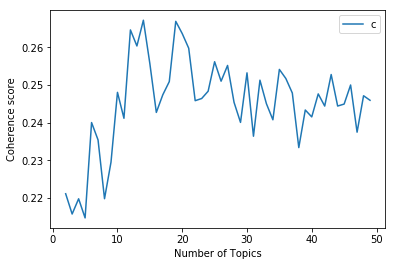

In [20]:
print "determining the number of topics"
def tokenize_titles(titles):

    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()
    texts = []
    for title in titles:
        raw = title.decode('utf-8').strip().lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [token for token in tokens if not token in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
    return texts

words = tokenize_titles(sampled_titles)
dictionary = corpora.Dictionary(words)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in words]
def compute_plot_coherence_values(doc_term_matrix, stop, start=2, step=1):

    coherence_values = []
    model_list = []
    num_options = range(start, stop, step)
    for num_topics in num_options:
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=words, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    print "coherence scores: {}".format(coherence_values)
    print "plotting coherence score for different number of topics" 
    plt.plot(num_options, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence scores"), loc='best')
    plt.show()

compute_plot_coherence_values(doc_term_matrix, 50, 2, 1)

In [2]:
print "setting num of topics to be 14"
n_topics = 14
lsa_model = Topic_Model(df, model_type='LSA', max_features=40000, n_components=n_topics)
lsa_model.get_top_n_topics(count_vectorizer_limited, 10)

setting num of topics to be 14
initialing & fitting LSA model...
generating categories...
keys done
categories
top 10 words for each topic by LSA:
('Topic 1: ', u'police attack india year syrian minister 000 war said pakistan')
('Topic 2: ', u'china sea south chinese new japan world korea beijing india')
('Topic 3: ', u'korea north south korean nuclear kim says jong missile africa')
('Topic 4: ', u'new zealand korea law york iran year times south minister')
('Topic 5: ', u'says minister russia iran ukraine report eu chief official russian')
('Topic 6: ', u'syria russia military assad putin weapons war turkey rebels russian')
('Topic 7: ', u'russia ukraine russian police putin crimea ukrainian crisis moscow eastern')
('Topic 8: ', u'iran nuclear news bbc deal world japan plant fukushima israel')
('Topic 9: ', u'world news war syria cup climate says year people largest')
('Topic 10: ', u'government uk president syrian parliament eu venezuela country anti protest')
('Topic 11: ', u'israel

initialing & fitting LSA model...
generating categories...
keys done
categories
self.categories:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
top_3_words:[u'says attack syrian', u'china sea south', u'new zealand government', u'says korea north', u'korea north south', u'syria iran nuclear', u'iran police nuclear', u'world news bbc', u'russia ukraine russian', u'president obama venezuela', u'israel gaza israeli', u'state killed islamic', u'government uk war', u'people year 000']
Frequency of the 14 topics by LSA:


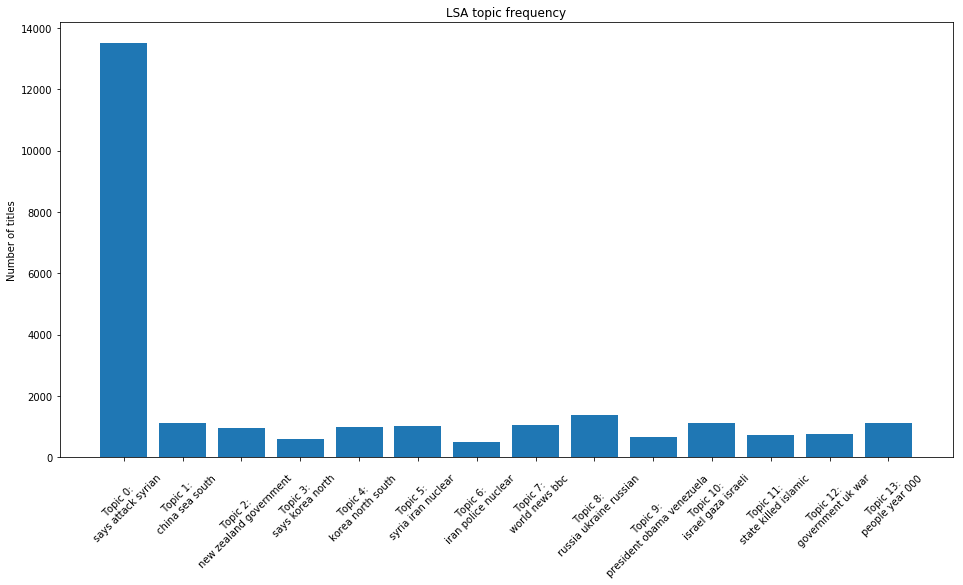

In [5]:
lsa_model = Topic_Model(df, model_type='LSA', max_features=40000, n_components=14)
lsa_model.plot_num_title_of_each_topic(count_vectorizer_limited)

initialing & fitting LSA model...
generating categories...
keys done
categories
use t-SNE to visualize LSA high dimensional dataset
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 25462 samples in 0.023s...
[t-SNE] Computed neighbors for 25462 samples in 9.210s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25462
[t-SNE] Computed conditional probabilities for sample 2000 / 25462
[t-SNE] Computed conditional probabilities for sample 3000 / 25462
[t-SNE] Computed conditional probabilities for sample 4000 / 25462
[t-SNE] Computed conditional probabilities for sample 5000 / 25462
[t-SNE] Computed conditional probabilities for sample 6000 / 25462
[t-SNE] Computed conditional probabilities for sample 7000 / 25462
[t-SNE] Computed conditional probabilities for sample 8000 / 25462
[t-SNE] Computed conditional probabilities for sample 9000 / 25462
[t-SNE] Computed conditional probabilities for sample 10000 / 25462
[t-SNE] Computed conditional probabilities for sample

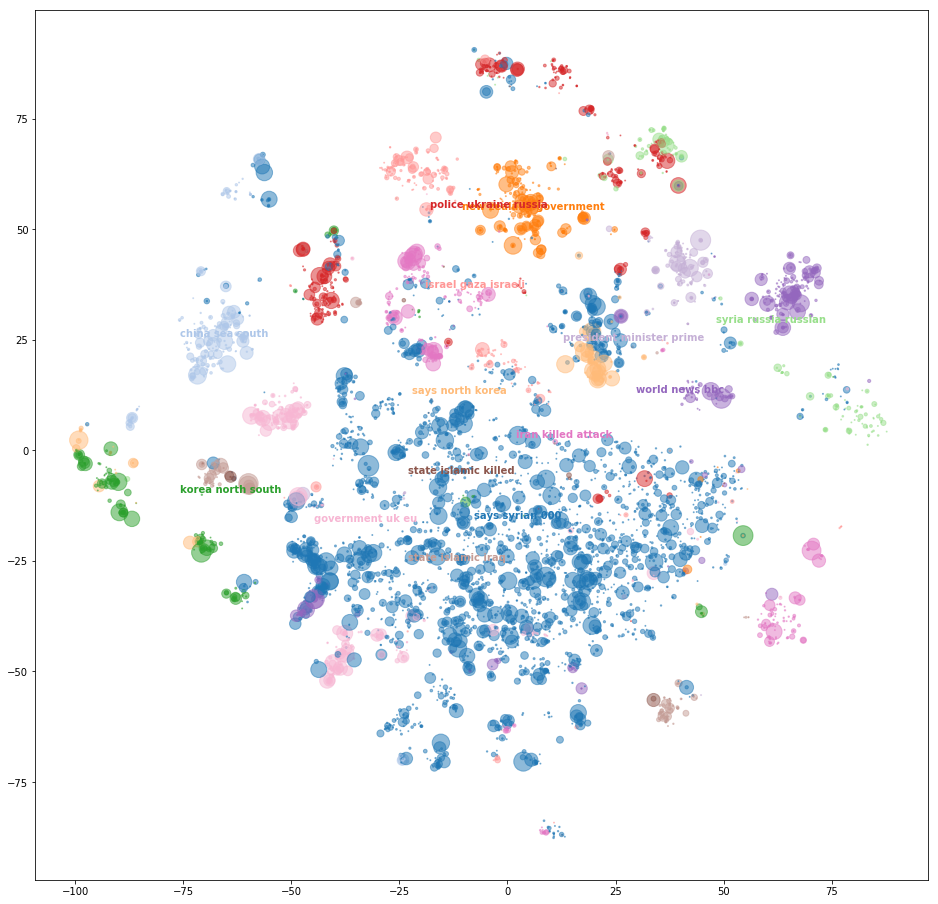

In [11]:
lsa_model = Topic_Model(df, model_type='LSA', max_features=40000, n_components=14)
lsa_model.visualize_tnse_2_dimension(count_vectorizer_limited)

In [13]:
print "Try LDA"
lda_model = Topic_Model(df, model_type='LDA', max_features=40000, learning_method='online', n_components=14, random_state=0, verbose=1)
lda_model.get_top_n_topics(count_vectorizer_limited, 10)

Try LDA
initialing & fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
generating categories...
keys done
categories
top 10 words for each topic by LDA:
('Topic 1: ', u'police government syria war attack dead egypt forces country al')
('Topic 2: ', u'says libya muslim missing france flight church malaysia group face')
('Topic 3: ', u'china chinese india new russian plane putin sea military south')
('Topic 4: ', u'world israeli japan new eu palestinian russia mexico gay afghanistan')
('Topic 5: ', u'iran russia syria nuclear says president turkey new deal russian')
('Topic 6: ', u'uk climate change death law bank west ebola world police')
('Topic 7: ', u'killed people pope year says attacks haram boko death president')
('Topic 8:

initialing & fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
generating categories...
keys done
categories
self.categories:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
top_3_words:[u'korea north iran', u'russian war rights', u'syria syrian al', u'china new world', u'israel gaza says', u'says police government', u'minister death prime', u'japan nuclear oil', u'news says state', u'israeli says india', u'new year old', u'election afghanistan pope', u'china attack killed', u'police saudi turkey']
Frequency of the 14 topics by LDA:


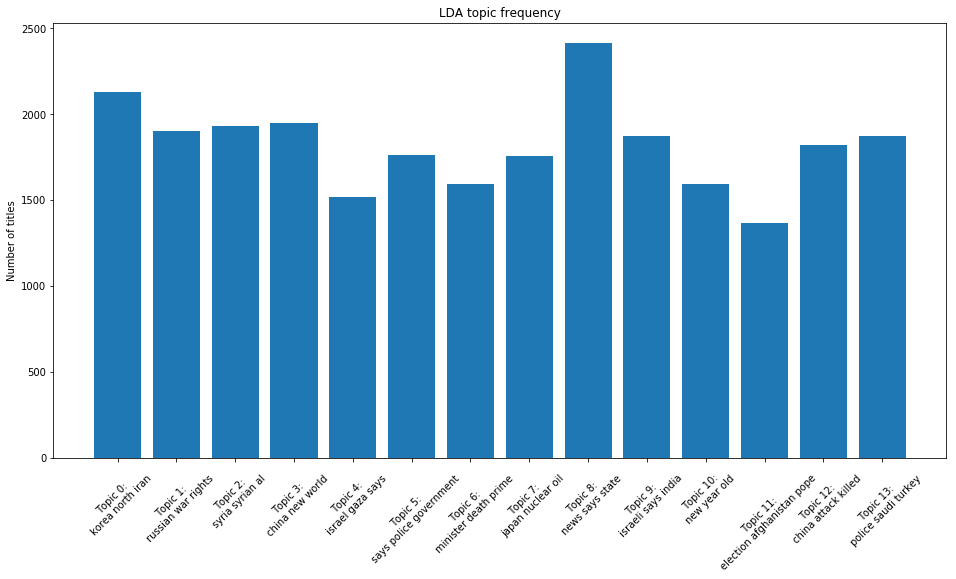

In [14]:
lda_model = Topic_Model(df, model_type='LDA', max_features=40000, learning_method='online', n_components=14, random_state=0, verbose=1)
lda_model.plot_num_title_of_each_topic(count_vectorizer_limited)

initialing & fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
generating categories...
keys done
categories
use t-SNE to visualize LDA high dimensional dataset
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 25462 samples in 0.014s...
[t-SNE] Computed neighbors for 25462 samples in 17.525s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25462
[t-SNE] Computed conditional probabilities for sample 2000 / 25462
[t-SNE] Computed conditional probabilities for sample 3000 / 25462
[t-SNE] Computed conditional probabilities for sample 4000 / 25462
[t-SNE] Computed conditional probabilities for sample 5000 / 25462
[t-SNE] Computed conditional probabilities for sample 6000 / 25462
[t-SNE] Computed conditional p

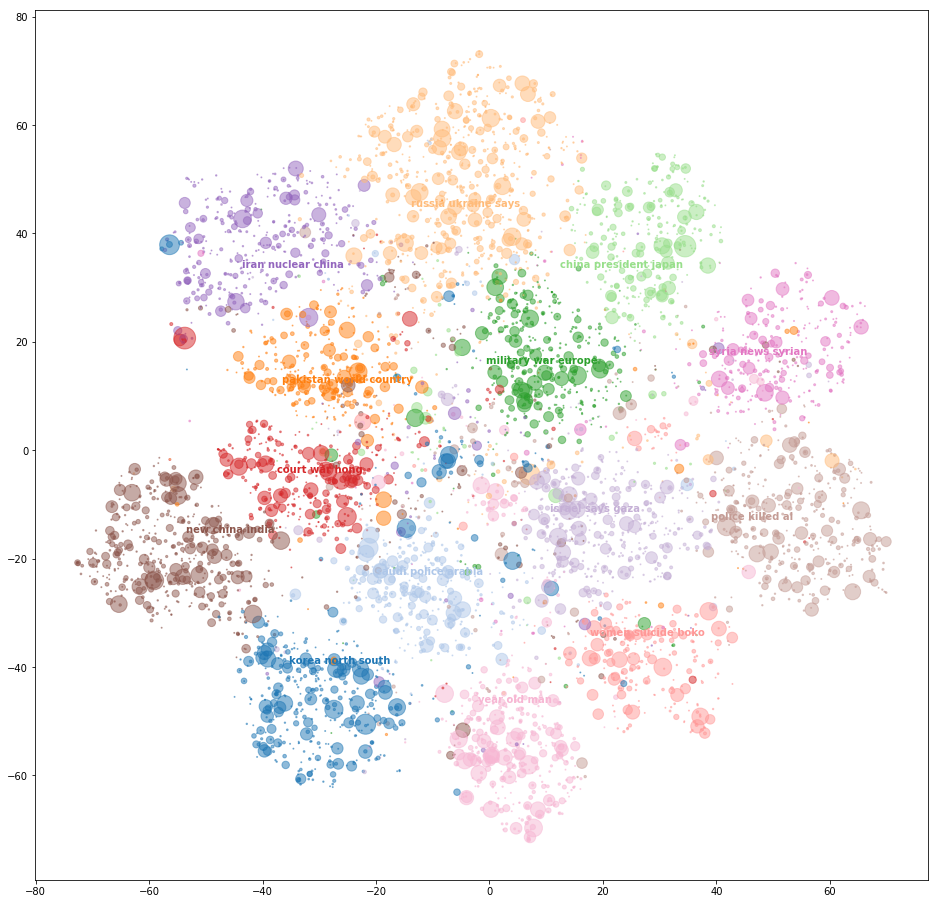

In [15]:
lda_model = Topic_Model(df, model_type='LDA', max_features=40000, learning_method='online', n_components=14, random_state=0, verbose=1)
lda_model.visualize_tnse_2_dimension(count_vectorizer_limited)

In [2]:
print "Scale up to the entire dataset"
print "lazy loading dataset..."
entire_df = df
entire_titles = entire_df['title'].compute().values
entire_up_votes = entire_df['up_votes'].compute().values
print "Done."

Scale up to the entire dataset
lazy loading dataset...
Done.


In [ ]:
print "initializing LDA model..."
entire_lda_model = Topic_Model(entire_df, sample_rate=0.2, model_type='LDA', max_features=100000, learning_method='online', n_components=14, random_state=0, verbose=1)
entire_lda_model.visualize_tnse_2_dimension(count_vectorizer_limited)

initializing LDA model...
initialing & fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
generating categories...
keys done
categories
use t-SNE to visualize LDA high dimensional dataset
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 101847 samples in 0.102s...
[t-SNE] Computed neighbors for 101847 samples in 268.542s...
[t-SNE] Computed conditional probabilities for sample 1000 / 101847
[t-SNE] Computed conditional probabilities for sample 2000 / 101847
[t-SNE] Computed conditional probabilities for sample 3000 / 101847
[t-SNE] Computed conditional probabilities for sample 4000 / 101847
[t-SNE] Computed conditional probabilities for sample 5000 / 101847
[t-SNE] Computed conditional probabilities for sample 6000 / 10

In [4]:
entire_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
print "count_vectorizer initialized"
entire_document_term_matrix = entire_count_vectorizer.fit_transform(entire_titles)
print "entire_document_term_matrix initialized"
entire_lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=0, verbose=1)
print "LDA model initialized"
entire_lda_model.fit(entire_document_term_matrix);
print "training on the entire dataset done."

count_vectorizer initialized
entire_document_term_matrix initialized
LDA model initialized
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
training on the entire dataset done.


In [8]:
years = df['date_created'].dt.year.compute()
start_year, end_year = min(years), max(years)
yearly_topics = {}
for year in range(start_year, end_year + 1):
    print "tackling {} topics...".format(year)
    yearly_ds = df[df['date_created'].dt.year == year]
    yearly_ds_titles = yearly_ds['title'].compute().values
    count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
    document_term_matrix = count_vectorizer.fit_transform(yearly_ds_titles)
    lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', verbose=0)
    topic_matrix = lda_model.fit_transform(document_term_matrix)
    keys = get_keys(topic_matrix)
    categories, counts = keys_to_counts(keys)
    top_n_words = get_top_n_words(1, 10, document_term_matrix, keys, count_vectorizer)
    yearly_topics[year] = top_n_words
for key in yearly_topics:
    print "{} top 10 topic words: {}".format(key, yearly_topics[key])

tackling 2008 topics...
tackling 2009 topics...
tackling 2010 topics...
tackling 2011 topics...
tackling 2012 topics...
tackling 2013 topics...
tackling 2014 topics...
tackling 2015 topics...
tackling 2016 topics...
2016 top 10 topic words: [u'minister', u'police', u'korea', u'china', u'china', u'saudi', u'india', u'syria', u'eu', u'israel']
2008 top 10 topic words: [u'oil', u'iraq', u'china', u'police', u'000', u'war', u'new', u'saudi', u'pakistan', u'iran']
2009 top 10 topic words: [u'world', u'obama', u'israel', u'police', u'president', u'gaza', u'korea', u'uk', u'israel', u'flu']
2010 top 10 topic words: [u'people', u'police', u'israel', u'oil', u'wikileaks', u'world', u'israel', u'haiti', u'rights', u'israel']
2011 top 10 topic words: [u'gaddafi', u'china', u'nuclear', u'news', u'south', u'al', u'protesters', u'egypt', u'libya', u'protests']
2012 top 10 topic words: [u'iran', u'india', u'egypt', u'north', u'minister', u'syrian', u'israel', u'china', u'news', u'syria']
2013 top 10 

In [28]:
years = df['date_created'].dt.year.compute()

start_year, end_year = min(years), max(years)
print "year range: {} to {}".format(start_year, end_year)
yearly_data = []
print "aggregating yearly titles..."
for year in range(start_year, end_year + 1):
    yearly_data.append(df[df['date_created'].dt.year == year]['title'].values.compute())
print "training LDA model..."
yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = entire_count_vectorizer.transform(year)
    topic_matrix = entire_lda_model.transform(document_term_matrix)
    keys = get_keys(topic_matrix)
    topic_words = get_top_n_words(10, 1, document_term_matrix, keys, entire_count_vectorizer)
    
    #yearly_topic_matrices.append(topic_matrix)
#print "yearly_topic_matrices:{}".format(yearly_topic_matrices)
    
yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
print "yearly_keys:{}".format(yearly_keys)

yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)
print "yearly_counts:{}".format(yearly_counts)
    
yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(start_year, end_year + 1))
yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(entire_lda_model.n_components)]

print yearly_topic_counts

year range: 2008 to 2016
aggregating yearly titles...
training LDA model...
yearly_topic_matrices:[array([[0.02      , 0.02      , 0.81999936, ..., 0.02000064, 0.02      ,
        0.02      ],
       [0.22000013, 0.02      , 0.02      , ..., 0.22      , 0.02      ,
        0.02      ],
       [0.02      , 0.02      , 0.82      , ..., 0.02      , 0.02      ,
        0.02      ],
       ...,
       [0.01111111, 0.12222263, 0.01111111, ..., 0.3444451 , 0.1222225 ,
        0.23333212],
       [0.01428571, 0.15714285, 0.30000002, ..., 0.15714286, 0.01428571,
        0.01428571],
       [0.0125    , 0.0125    , 0.0125    , ..., 0.38749986, 0.0125    ,
        0.13750003]]), array([[0.1909089 , 0.00909091, 0.00909159, ..., 0.09999977, 0.19090954,
        0.09999929],
       [0.01428571, 0.01428571, 0.15714285, ..., 0.01428571, 0.01428571,
        0.01428571],
       [0.13749991, 0.0125    , 0.13750004, ..., 0.0125    , 0.1375    ,
        0.0125    ],
       ...,
       [0.0125    , 0.1374998

yearly_counts:[[2121, 2251, 2577, 2122, 2144, 2279, 2138, 2104, 2548, 2221], [2378, 2179, 3717, 2184, 2317, 2303, 2219, 2206, 3021, 2591], [2076, 1923, 3202, 2032, 2215, 2151, 2358, 2211, 2904, 2241], [3247, 3738, 4422, 2848, 3578, 3625, 4476, 5781, 3872, 3299], [3697, 3692, 4321, 3272, 4404, 4104, 5452, 5129, 4924, 3648], [7913, 7803, 8925, 6776, 9070, 9257, 10846, 9048, 10108, 8485], [8542, 7469, 10705, 7727, 9486, 11331, 10350, 9591, 8528, 8301], [8350, 6908, 9855, 8520, 9788, 10746, 11909, 10184, 10183, 8178], [7550, 6145, 7124, 6794, 8048, 9695, 10984, 9008, 8914, 7630]]
      Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  Topic 8  \
2008     2121     2251     2577     2122     2144     2279     2138     2104   
2009     2378     2179     3717     2184     2317     2303     2219     2206   
2010     2076     1923     3202     2032     2215     2151     2358     2211   
2011     3247     3738     4422     2848     3578     3625     4476     5781   
2012     3697    